# Generate "clean" reference dataset

In this notebook, we'll read the assembled PBMC reference dataset and remove cell types flagged as Doublets, Contamination, or with high mitochondrial content. We'll then re-project the clean reference for use in visualization and for construction of reference models.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from datetime import date
import hisepy
import os
import pandas as pd
import scanpy as sc
import scanpy.external as sce

In [2]:
def read_adata_uuid(h5ad_uuid):
    h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)
    if not os.path.isdir(h5ad_path):
        hise_res = hisepy.reader.cache_files([h5ad_uuid])
    h5ad_filename = os.listdir(h5ad_path)[0]
    h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)
    adata = sc.read_h5ad(h5ad_file)
    return adata

## Read annotated dataset

In [3]:
h5ad_uuid = 'b4ff2a4a-ce8c-4e86-88fa-4761d5fef221'

In [4]:
adata = read_adata_uuid(h5ad_uuid)

In [5]:
adata.shape

(1952128, 1236)

## Filter cell types

In [6]:
exclude_terms = [
    'Contamination', 'contamination',
    'Doublet', 'doublet',
    'Mito', 'mito'
]

In [7]:
all_types = adata.obs['AIFI_L3'].unique().tolist()

In [8]:
exclude_types = []
for cell_type in all_types:
    for term in exclude_terms:
        if term in cell_type:
            exclude_types.append(cell_type)

In [9]:
exclude_types

['Contamination',
 'Naive CD8 T cell Platelet Doublets',
 'T_B doublet',
 'C5_C12_Contamination',
 'Doublet',
 'T+Erythocytes doublet',
 'NK+T Doublets',
 'Monocytes+Erythocytes doublet',
 'Proliferating Cells+Monocytes Doublets',
 'NK_Mono doublet',
 'B_mono doublet',
 'B_platelet doublet',
 'CD4 naive Platelet Doublets',
 'Erythrocyte contamination',
 'CD4 naive CD16 Monocytes Doublets',
 'CD56dim Mito+ NK',
 'NK+Platelet Doublet',
 'B+Erythocytes doublet',
 'NK+Erythocytes Doublet',
 'NK+Erythocytes doublet']

In [10]:
keep_types = []
for cell_type in all_types:
    if not cell_type in exclude_types:
        keep_types.append(cell_type)

## How many are excluded?

In [11]:
all_counts = adata.obs['AIFI_L3'].value_counts()
n_all = sum(all_counts)
n_all

1952128

In [12]:
exclude_counts = all_counts[exclude_types]

In [13]:
exclude_counts

AIFI_L3
Contamination                             10233
Naive CD8 T cell Platelet Doublets        14199
T_B doublet                                2803
C5_C12_Contamination                       1937
Doublet                                   46150
T+Erythocytes doublet                      9148
NK+T Doublets                              5494
Monocytes+Erythocytes doublet              2491
Proliferating Cells+Monocytes Doublets      122
NK_Mono doublet                            2114
B_mono doublet                             2535
B_platelet doublet                         3948
CD4 naive Platelet Doublets                5769
Erythrocyte contamination                  5962
CD4 naive CD16 Monocytes Doublets          1367
CD56dim Mito+ NK                           2768
NK+Platelet Doublet                        4214
B+Erythocytes doublet                       953
NK+Erythocytes Doublet                     5181
NK+Erythocytes doublet                     1074
Name: count, dtype: int64

In [14]:
n_exclude = sum(exclude_counts)
n_exclude

128462

Percent removed:

In [15]:
n_exclude / n_all * 100

6.58061356632352

## Generate filtered object

In [16]:
adata.obs['keep'] = adata.obs['AIFI_L3'].isin(keep_types).astype('category')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


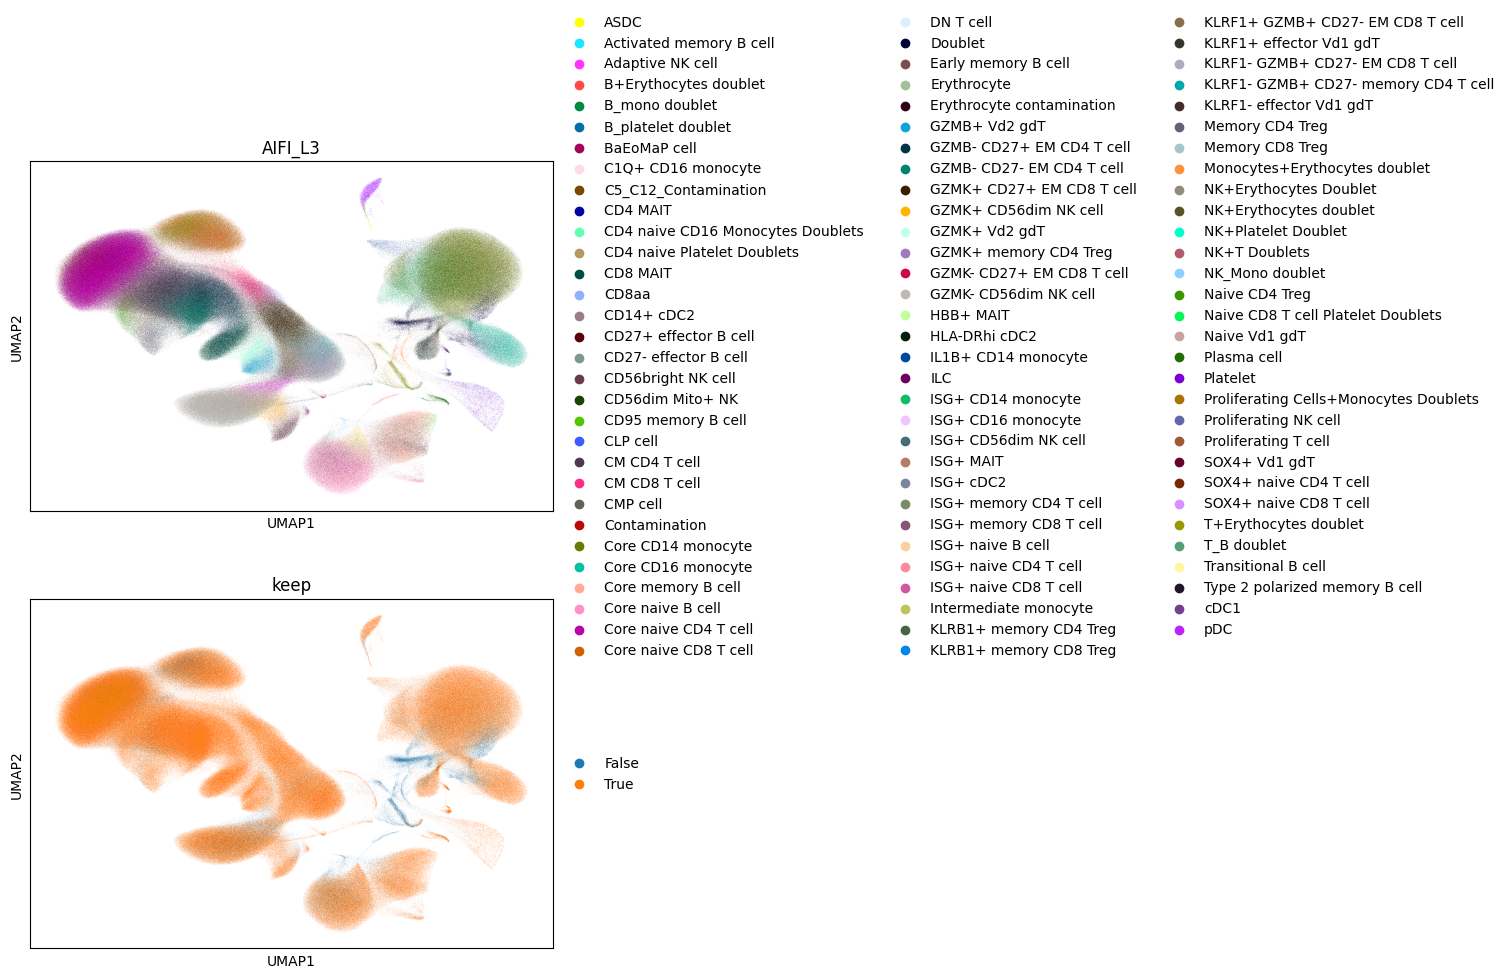

In [17]:
sc.pl.umap(
    adata,
    color = ['AIFI_L3', 'keep'],
    ncols = 1
)

In [18]:
adata_subset = adata[adata.obs['AIFI_L3'].isin(keep_types)]
adata_subset.shape

(1823666, 1236)

In [19]:
obs = adata_subset.obs.copy()
obs['AIFI_L1'] = obs['AIFI_L1'].cat.remove_unused_categories()
obs['AIFI_L2'] = obs['AIFI_L2'].cat.remove_unused_categories()
obs['AIFI_L3'] = obs['AIFI_L3'].cat.remove_unused_categories()
adata_subset.obs = obs

In [ ]:
sc.pl.umap(
    adata_subset,
    color = ['AIFI_L1', 'AIFI_L2', 'AIFI_L3'],
    ncols = 1
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


## Re-project with the cleaned up data only

Now that we've removed the doublets and contamination, we'll redo variable feature selection and generate an updated UMAP projection.

In [ ]:
adata_subset = adata_subset.raw.to_adata()

In [ ]:
adata_subset.raw = adata_subset

In [ ]:
sc.pp.normalize_total(adata_subset, target_sum = 1e4)

In [ ]:
sc.pp.log1p(adata_subset)
sc.pp.highly_variable_genes(adata_subset)

In [25]:
adata_subset = adata_subset[:, adata_subset.var_names[adata_subset.var['highly_variable']]].copy()

In [26]:
sc.pp.scale(adata_subset)

In [27]:
sc.tl.pca(adata_subset, svd_solver='arpack')

In [28]:
sce.pp.harmony_integrate(
    adata_subset, 
    'cohort.cohortGuid',
    max_iter_harmony = 30)

2024-03-08 05:31:39,324 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-08 05:39:43,168 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-08 05:39:49,900 - harmonypy - INFO - Iteration 1 of 30
2024-03-08 05:51:08,238 - harmonypy - INFO - Iteration 2 of 30
2024-03-08 06:02:45,126 - harmonypy - INFO - Iteration 3 of 30
2024-03-08 06:14:02,162 - harmonypy - INFO - Iteration 4 of 30
2024-03-08 06:25:43,568 - harmonypy - INFO - Iteration 5 of 30
2024-03-08 06:37:00,442 - harmonypy - INFO - Iteration 6 of 30
2024-03-08 06:48:18,777 - harmonypy - INFO - Iteration 7 of 30
2024-03-08 06:59:32,466 - harmonypy - INFO - Iteration 8 of 30
2024-03-08 07:10:51,516 - harmonypy - INFO - Iteration 9 of 30
2024-03-08 07:17:36,412 - harmonypy - INFO - Converged after 9 iterations


In [29]:
sc.pp.neighbors(
    adata_subset, 
    n_neighbors = 50,
    use_rep = 'X_pca_harmony', 
    n_pcs = 30)

In [ ]:
sc.tl.umap(adata_subset, min_dist = 0.05)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


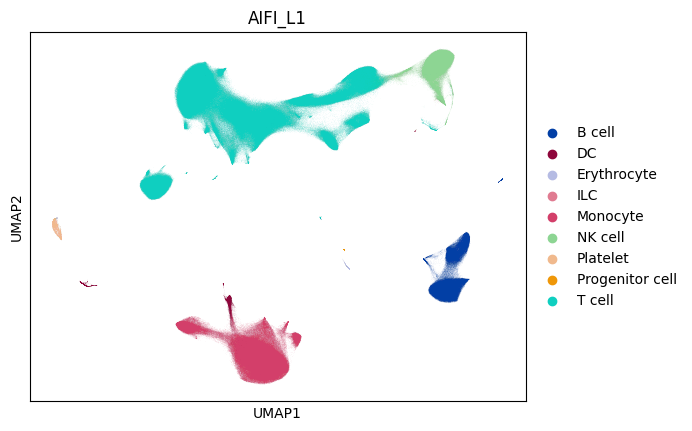

In [53]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L1'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


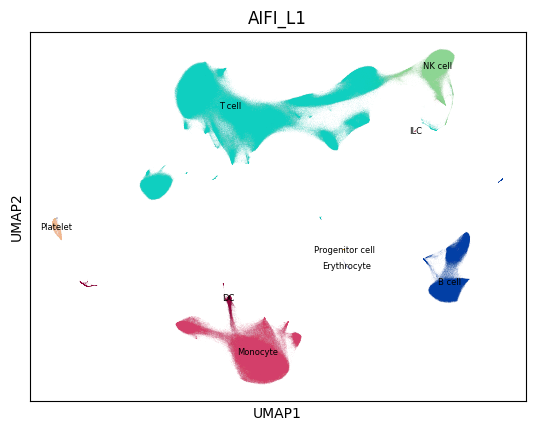

In [60]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L1',
    legend_loc = 'on data',
    legend_fontsize = 6,
    legend_fontweight = 'normal'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


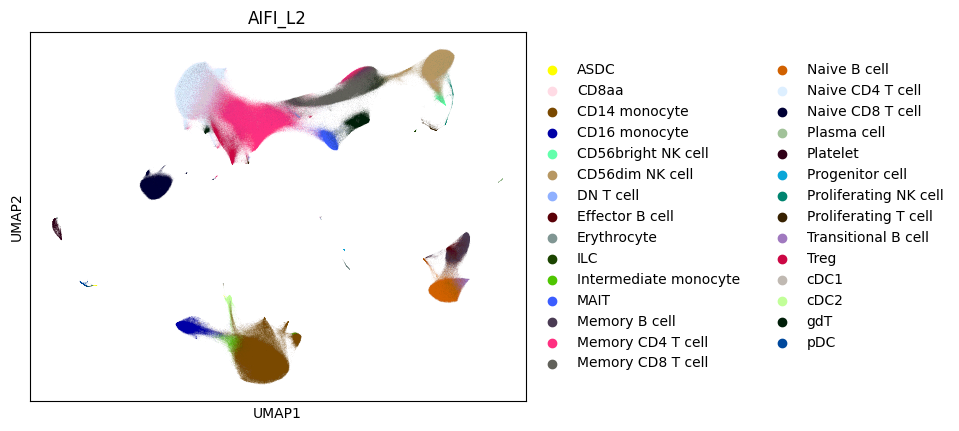

In [64]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L2'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


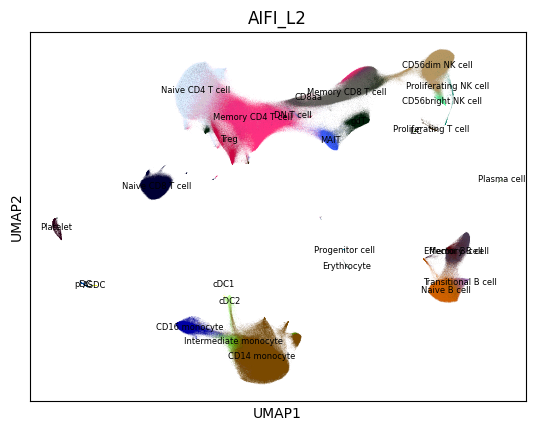

In [65]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L2',
    legend_loc = 'on data',
    legend_fontsize = 6,
    legend_fontweight = 'normal'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


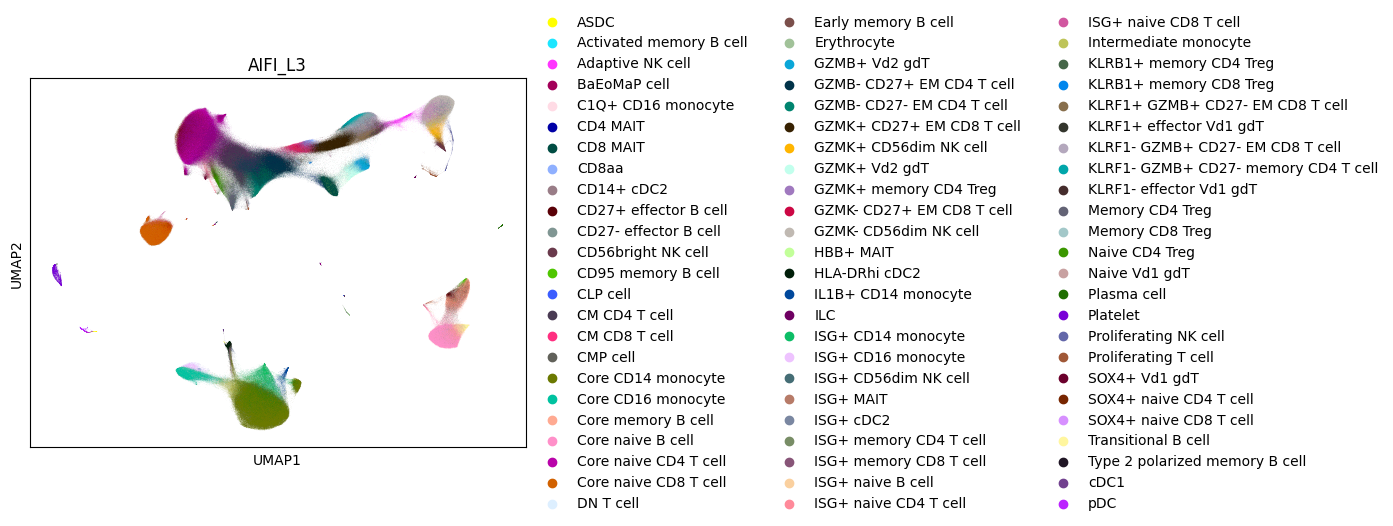

In [55]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L3'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


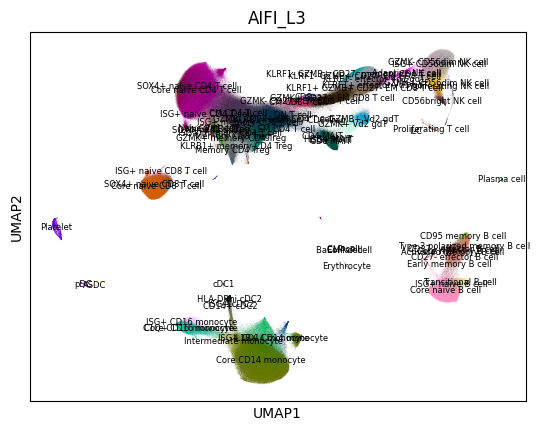

In [66]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L3',
    legend_loc = 'on data',
    legend_fontsize = 6,
    legend_fontweight = 'normal'
)

## Output final annotations

In [ ]:
obs = adata.obs
obs = obs.reset_index(drop = True)

In [ ]:
umap_mat = adata.obsm['X_umap']
umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])
obs['umap_1'] = umap_df['umap_1']
obs['umap_2'] = umap_df['umap_2']

In [ ]:
obs.head()

In [ ]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [ ]:
obs_out_csv = '{p}/ref_pbmc_clean_labeled_meta_umap_{d}.csv'.format(p = out_dir, d = date.today())
obs.to_csv(obs_out_csv, index = False)

In [ ]:
obs_out_parquet = '{p}/ref_pbmc_clean_labeled_meta_umap_{d}.parquet'.format(p = out_dir, d = date.today())
obs.to_parquet(obs_out_parquet, index = False)

In [ ]:
bc_anno = obs[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]

In [ ]:
label_out_csv = '{p}/ref_pbmc_clean_barcode_labels_{d}.csv'.format(p = out_dir, d = date.today())
bc_anno.to_csv(label_out_csv, index = False)

In [ ]:
label_out_parquet = '{p}/ref_pbmc_clean_barcode_labels_{d}.parquet'.format(p = out_dir, d = date.today())
bc_anno.to_parquet(label_out_parquet, index = False)

## Output labeled AnnData

In [ ]:
out_h5ad = '{p}/ref_pbmc_clean_labeled_{d}.h5ad'.format(p = out_dir, d = date.today())
adata.write_h5ad(out_h5ad)

## Upload results to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [45]:
study_space_uuid = '64097865-486d-43b3-8f94-74994e0a72e0'
title = 'Clean 10x 3-prime PBMC Reference {d}'.format(d = date.today())

In [47]:
in_files = [h5ad_uuid]

In [48]:
in_files

['b4ff2a4a-ce8c-4e86-88fa-4761d5fef221']

In [49]:
out_files = [out_h5ad,
             obs_out_csv, obs_out_parquet,
             label_out_csv, label_out_parquet]

In [50]:
out_files

['output/ref_pbmc_clean_labeled_2024-03-08.h5ad',
 'output/ref_pbmc_clean_labeled_meta_umap_2024-03-08.csv',
 'output/ref_pbmc_clean_labeled_meta_umap_2024-03-08.parquet',
 'output/ref_pbmc_clean_barcode_labels_2024-03-08.csv',
 'output/ref_pbmc_clean_barcode_labels_2024-03-08.parquet']

In [51]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files
)

output/ref_pbmc_clean_labeled_2024-03-08.h5ad
output/ref_pbmc_clean_labeled_meta_umap_2024-03-08.csv
output/ref_pbmc_clean_labeled_meta_umap_2024-03-08.parquet
output/ref_pbmc_clean_barcode_labels_2024-03-08.csv
output/ref_pbmc_clean_barcode_labels_2024-03-08.parquet
you are trying to upload file_ids... ['output/ref_pbmc_clean_labeled_2024-03-08.h5ad', 'output/ref_pbmc_clean_labeled_meta_umap_2024-03-08.csv', 'output/ref_pbmc_clean_labeled_meta_umap_2024-03-08.parquet', 'output/ref_pbmc_clean_barcode_labels_2024-03-08.csv', 'output/ref_pbmc_clean_barcode_labels_2024-03-08.parquet']. Do you truly want to proceed?


(y/n) y


{'trace_id': 'f1315087-4621-4f67-a2d4-e72b56286a4f',
 'files': ['output/ref_pbmc_clean_labeled_2024-03-08.h5ad',
  'output/ref_pbmc_clean_labeled_meta_umap_2024-03-08.csv',
  'output/ref_pbmc_clean_labeled_meta_umap_2024-03-08.parquet',
  'output/ref_pbmc_clean_barcode_labels_2024-03-08.csv',
  'output/ref_pbmc_clean_barcode_labels_2024-03-08.parquet']}

In [52]:
import session_info
session_info.show()